In [1]:
import re  # For regular expressions
import os  # For interacting with the operating system
import sys  # For interacting with the Python interpreter
import math  # For mathematical operations
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt  # For data visualization
import matplotlib.dates as mdates  # For working with dates
import datetime  # For working with dates and times
import warnings  # For suppressing warnings
from pathlib import PurePath # For file path management
warnings.filterwarnings("ignore")  # Ignore warning messages

## Pre-defined parameters

- **threshold**: Represents the distance parameter used by the wind transpose model (1/2/4 times the experimental area radius).
- **duration**: Denotes the minimum event length in Stanford Defined Events that should be disregarded (30/60/120 seconds).

In [2]:
threshold = 2
duration = 60

## 1. Load Datasets

1. Stanford-Defined Events Dataset (Camera-based): Includes positive events (non-zero release periods) and negative events (zero release periods)
2. Stanford-Defined Events Dataset (Sensor-based):  Contains positive events (non-zero release periods) and negative events (zero release periods)
3. Team-Defined Events Dataset(Camera-based): Categorized with Positive, Negative, and N/A labels for camera-based operators: Andium, Oiler, Kuva
4. Team-Defined Events Dataset(Sensor-based): Categorized with Positive, Negative, and N/A labels for sensor-based operators: Canary, Ecoteco, Qube, Sensirion

In [3]:
# 1. Stanford-Defined Events Dataset(Camera-based)
# which saved in the file: assets/events/PN/candidate_event_duration=60xseconds_[P/N/NA].csv

print("Loading data for camera-based stanford-defined events...")
camera_based_stanford_defined_events_p = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_P.csv')
camera_based_stanford_defined_events_n = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_N.csv')
camera_based_stanford_defined_events_na = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_NA.csv')
print("Loaded data for camera-based stanford-defined events")

# 2. Stanford-Defined Events Dataset(Sensor-based)
# which saved in the file: assets/events/PN/true_event_threshold=2xradius_duration=60xseconds_[P/N/NA].csv

print("Loading data for sensor-based stanford-defined events...")
sensor_based_stanford_defined_events_p = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_P.csv')
sensor_based_stanford_defined_events_n = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_N.csv')
sensor_based_stanford_defined_events_na = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_NA.csv')
print("Loaded data for sensor-based stanford-defined events")


# 3. Team-Defined Events Dataset
# which stored in the file: assets/sensor_data/[sensor_name]_caliddata.csv

sensor_names = [
    "Andium", 
    "Canary",
    "Ecoteco",
    "Kuva",
    "Oiler",
    "Qube",
    "Sensirion"
]

camera_based_sensor_names = [
    "Andium", 
    "Kuva",
    "Oiler"
]
sensor_based_sensor_names = [
    "Canary",
    "Ecoteco",
    "Qube",
    "Sensirion"
]

df_team_defined_events = {}
for sn in sensor_names:
    print("Loading data for sensor: " + sn, end="\t")
    df_team_defined_events[sn] = pd.read_csv(
        '../../assets/sensor_data/' + sn + '_validdata.csv', 
        parse_dates=['EmissionStartDateTime', "EmissionEndDateTime"]
    )[["EmissionStartDateTime", "EmissionEndDateTime", "ReportLabel"]]
    print("Done.")


Loading data for camera-based stanford-defined events...
Loaded data for camera-based stanford-defined events
Loading data for sensor-based stanford-defined events...
Loaded data for sensor-based stanford-defined events
Loading data for sensor: Andium	Done.
Loading data for sensor: Canary	Done.
Loading data for sensor: Ecoteco	Done.
Loading data for sensor: Kuva	Done.
Loading data for sensor: Oiler	Done.
Loading data for sensor: Qube	Done.
Loading data for sensor: Sensirion	Done.


## 2. Overlap-based Filtering and Detection

For each team(both camera-based and sensor-based), perform the following operations:

1. Calculate the overlap ratio as follows:
    - Calculate the total overlap ratio between the current Team-defined event and all positive events in the overlapped Stanford-defined events, marked as POR (Positive Overlap Ratio)
    - Calculate the total overlap ratio between the current Team-defined event and all negative events in the overlapped Stanford-defined events, marked as NOR (Negative Overlap Ratio)
    - Normalize POR and NOR as follows: POR = POR / (POR + NOR), NOR = NOR / (POR + NOR)

3. classifier Team-defined events using the following criterias:
    - 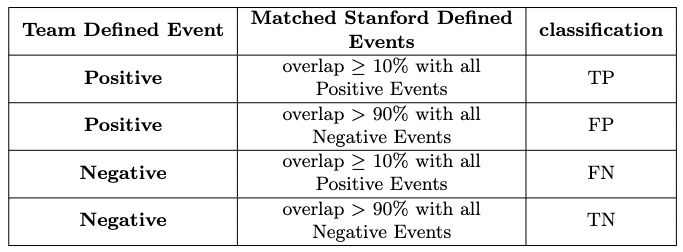

4. calculate detection Metrics for Team Defined Events
    - 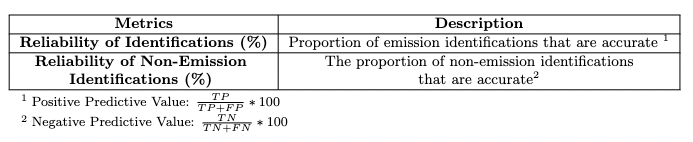

In [4]:
match_dfs = {
    "Andium": [],
    "Canary": [],
    "Ecoteco": [],
    "Kuva": [],
    "Oiler": [],
    "Qube": [],
    "Sensirion": []
}


for sn in sensor_names:
    print("=" * 20, end="\t")
    print("Processing sensor: " + sn, end="\t")
    print("=" * 20)
    is_camera_based = sn in camera_based_sensor_names
    is_sensor_based = sn in sensor_based_sensor_names    

    team_defined_events = df_team_defined_events[sn]
    if is_camera_based:
        stanford_defined_events_p = camera_based_stanford_defined_events_p
        stanford_defined_events_n = camera_based_stanford_defined_events_n
        stanford_defined_events_na = camera_based_stanford_defined_events_na
    else:
        stanford_defined_events_p = sensor_based_stanford_defined_events_p
        stanford_defined_events_n = sensor_based_stanford_defined_events_n
        stanford_defined_events_na = sensor_based_stanford_defined_events_na

    team_defined_events = team_defined_events[team_defined_events["ReportLabel"] != str("NA")].reset_index(drop=True)

    stanford_defined_events = pd.concat([stanford_defined_events_p, stanford_defined_events_n, stanford_defined_events_na], axis=0)
    stanford_defined_events = stanford_defined_events.sort_values(by=['ManualStartDateTime']).reset_index(drop=True)

    stanford_defined_events["ManualStartDateTime"] = pd.to_datetime(stanford_defined_events["ManualStartDateTime"])
    stanford_defined_events["ManualEndDateTime"] = pd.to_datetime(stanford_defined_events["ManualEndDateTime"])

    # calculate overlap ratio of all team-defined events for each stanford-defined event
    for i in range(team_defined_events.shape[0]):
        team_defined_event = team_defined_events.iloc[i]
        team_defined_event_start = pd.to_datetime(team_defined_event["EmissionStartDateTime"])
        team_defined_event_end = pd.to_datetime(team_defined_event["EmissionEndDateTime"])
        team_defined_event_date = team_defined_event_start.date()
        team_defined_event_seconds = (team_defined_event_end - team_defined_event_start).total_seconds()
        team_defined_event_label = team_defined_event["ReportLabel"]

        if team_defined_event_label not in ["P", "N"]: # for soofie, ignore NA events
            continue

        stanford_defined_events_on_the_same_day = stanford_defined_events[stanford_defined_events["ManualStartDateTime"].dt.date == team_defined_event_date]

        overlap_ratio_positive = 0
        overlap_ratio_negative = 0
        overlap_ratio_na = 0
        if team_defined_event_end < team_defined_event_start:
            continue

        print("current team-defined event: ", team_defined_event_start, team_defined_event_end, team_defined_event_label)
        print("Calculating overlap ratio..", end="\t")
        for j in range(stanford_defined_events_on_the_same_day.shape[0]):
            stanford_defined_event = stanford_defined_events_on_the_same_day.iloc[j]
            stanford_defined_event_start = pd.to_datetime(stanford_defined_event["ManualStartDateTime"])
            stanford_defined_event_end = pd.to_datetime(stanford_defined_event["ManualEndDateTime"])
            stanford_defined_event_label = stanford_defined_event["Label"]

            if stanford_defined_event_start > team_defined_event_end or stanford_defined_event_end < team_defined_event_start:
                continue

            overlap_start = max(team_defined_event_start, stanford_defined_event_start)
            overlap_end = min(team_defined_event_end, stanford_defined_event_end)
            overlap_duration = (overlap_end - overlap_start).total_seconds() / (team_defined_event_seconds + 1)

            if stanford_defined_event_label == "P":
                overlap_ratio_positive += overlap_duration
            elif stanford_defined_event_label == "N":
                overlap_ratio_negative += overlap_duration
            else:
                overlap_ratio_na += overlap_duration
        print("Done.", end="\t")
        print(f"overlap_ratio_positive: {overlap_ratio_positive}, overlap_ratio_negative: {overlap_ratio_negative}, overlap_ratio_na: {overlap_ratio_na}")
        if overlap_ratio_positive + overlap_ratio_negative == 0:
            print(f"A team-defined event({team_defined_event_start}, {team_defined_event_end})" + \
                  "does not overlap with any stabford-defined events, ignore it.")
            continue
        print("Classifying stanford-defined event..", end="\t")
        
        POR = overlap_ratio_positive / (overlap_ratio_positive + overlap_ratio_negative)
        NOR = overlap_ratio_negative / (overlap_ratio_positive + overlap_ratio_negative)
        if team_defined_event_label == "P" and POR >= 0.1:
            team_defined_event_class = "TP"
        if team_defined_event_label == "P" and POR < 0.1:
            team_defined_event_class = "FP"
        if team_defined_event_label == "N" and POR >= 0.1:
            team_defined_event_class = "FN"
        if team_defined_event_label == "N" and POR < 0.1:
            team_defined_event_class = "TN"

        match_dfs[sn].append([
            sn, team_defined_event_class, team_defined_event_label, team_defined_event_start, team_defined_event_end, POR, NOR
        ])
        print("Done.", end="\t")
        print("Classification result: ", team_defined_event_class)

# transform list to dataframe
for sn in sensor_names:
    match_dfs[sn] = pd.DataFrame(data=match_dfs[sn], columns=["sensor", "label", "EventClass", "EventStart", "EventEnd", "POR", "NOR"])

====================	Processing sensor: Andium	====================
current team-defined event:  2022-10-10 16:50:46 2022-10-10 17:46:00 P
Calculating overlap ratio..	Done.	overlap_ratio_positive: 0.30226244343891406, overlap_ratio_negative: 0.044947209653092006, overlap_ratio_na: 0.1683257918552036
Classifying stanford-defined event..	Done.	Classification result:  TP
current team-defined event:  2022-10-10 17:46:01 2022-10-10 18:01:59 N
Calculating overlap ratio..	Done.	overlap_ratio_positive: 0, overlap_ratio_negative: 0.9895724713242962, overlap_ratio_na: 0.0072992700729927005
Classifying stanford-defined event..	Done.	Classification result:  TN
current team-defined event:  2022-10-10 18:02:00 2022-10-10 21:39:12 P
Calculating overlap ratio..	Done.	overlap_ratio_positive: 0.9849612522059388, overlap_ratio_negative: 7.672830507174097e-05, overlap_ratio_na: 0
Classifying stanford-defined event..	Done.	Classification result:  TP
current team-defined event:  2022-10-10 21:39:13 2022-10-

In [5]:
# calculate detection Metrics for Stanford Defined Events
metrics = []
metrics_name = ["Reliability of Identifications (%)", "Reliability of Non-Emission Identifications (%)"]
print("Calculating detection metrics..")
for sn in sensor_names:

    print("Processing sensor: " + sn, end="\t")
    n_tp = match_dfs[sn][match_dfs[sn]["label"] == "TP"].shape[0]
    n_fn = match_dfs[sn][match_dfs[sn]["label"] == "FN"].shape[0]

    n_fp = match_dfs[sn][match_dfs[sn]["label"] == "FP"].shape[0]
    n_tn = match_dfs[sn][match_dfs[sn]["label"] == "TN"].shape[0]

    reliability_of_identifications = n_tp / (n_tp + n_fp) * 100
    reliability_of_non_emission_identifications = n_tn / (n_tn + n_fn) * 100

    metrics.append([sn, reliability_of_identifications, reliability_of_non_emission_identifications])
    print("Done.", end="\t")
    print(f"Reliability of Identifications: {reliability_of_identifications}, Reliability of Non-Emission Identifications: {reliability_of_non_emission_identifications}")
    

Calculating detection metrics..
Processing sensor: Andium	Done.	Reliability of Identifications: 94.6236559139785, Reliability of Non-Emission Identifications: 60.0
Processing sensor: Canary	Done.	Reliability of Identifications: 90.9090909090909, Reliability of Non-Emission Identifications: 96.15384615384616
Processing sensor: Ecoteco	Done.	Reliability of Identifications: 73.45309381237524, Reliability of Non-Emission Identifications: 29.36802973977695
Processing sensor: Kuva	

Done.	Reliability of Identifications: 95.74468085106383, Reliability of Non-Emission Identifications: 43.47826086956522
Processing sensor: Oiler	Done.	Reliability of Identifications: 97.22222222222221, Reliability of Non-Emission Identifications: 28.000000000000004
Processing sensor: Qube	Done.	Reliability of Identifications: 86.20689655172413, Reliability of Non-Emission Identifications: 47.89915966386555
Processing sensor: Sensirion	Done.	Reliability of Identifications: 84.21052631578947, Reliability of Non-Emission Identifications: 90.66666666666666


## 3. Save Results

In [6]:
root_path = PurePath("../../results/03_DetectionAnalysis/Event-based ConfusionMatrix/Team Defined Events_Reliability")

# save detection metrics to csv file
metrics_df = pd.DataFrame(data=metrics, columns=["sensor"] + metrics_name)
metrics_df.to_csv(root_path / f"threshold={threshold}xradius_duration={duration}xseconds.csv", index=False)

# save match events to csv file
root_path = PurePath("../../results/03_DetectionAnalysis/Test-case Matching Data/Team Defined Events")
for sn in sensor_names:
    match_dfs[sn].to_csv(root_path / f"{threshold}xradius_{duration}xseconds_{sn}_match_events.csv", index=False)